In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas_datareader as web
#from datetime import datetime

# 207940.KS is the ticker for Samsung Biologics
df = web.DataReader('207940.KS', data_source='yahoo', start='2016-06-01', end='2021-11-16')
df


Bad key "text.kerning_factor" on line 4 in
C:\Users\joon7\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-11-11,186500,142000,149500,161500,8140539,161500
2016-11-14,177500,165000,165000,175500,2977177,175500
2016-11-15,181500,162500,179000,166000,2592949,166000
2016-11-16,173000,163500,168500,170000,1660976,170000
2016-11-17,177500,167500,176500,167500,912260,167500
...,...,...,...,...,...,...
2021-11-10,836000,814000,821000,820000,57089,820000
2021-11-11,820000,811000,813000,819000,39365,819000
2021-11-12,844000,820000,820000,833000,46428,833000


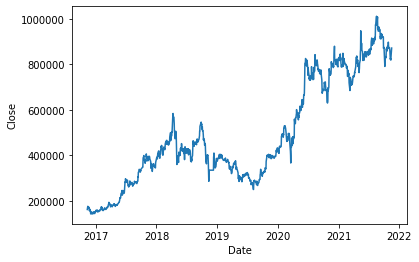

In [2]:
#Separate dates for future plotting
#train_dates = pd.to_datetime(df['Date'])
#train_dates
df = df.reset_index()
train_dates = df['Date']
train_dates

sns.lineplot(df['Date'], df['Close'])

In [3]:
#Variables for training
cols = list(df)[1:6]
cols

['High', 'Low', 'Open', 'Close', 'Volume']

In [4]:
df_for_training = df[cols].astype(float)
df_for_training

,High,Low,Open,Close,Volume
0,186500.0,142000.0,149500.0,161500.0,8140539.0
1,177500.0,165000.0,165000.0,175500.0,2977177.0
2,181500.0,162500.0,179000.0,166000.0,2592949.0
3,173000.0,163500.0,168500.0,170000.0,1660976.0
4,177500.0,167500.0,176500.0,167500.0,912260.0
...,...,...,...,...,...
1225,836000.0,814000.0,821000.0,820000.0,57089.0
1226,820000.0,811000.0,813000.0,819000.0,39365.0
1227,844000.0,820000.0,820000.0,833000.0,46428.0
1228,873000.0,840000.0,845000.0,864000.0,76609.0


In [5]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [6]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []

In [7]:
n_future = 1   # Number of days we want to predict into the future
n_past = 2     # Number of past days we want to use to predict the future

In [8]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [9]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
trainX

trainX shape == (1228, 2, 5).
trainY shape == (1228, 1).


array([[[-1.32422704, -1.48457314, -1.4650475 , -1.41559264,
         23.17894385],
        [-1.36266635, -1.3837309 , -1.39802595, -1.35491381,
          8.05910931]],

       [[-1.36266635, -1.3837309 , -1.39802595, -1.35491381,
          8.05910931],
        [-1.34558221, -1.39469202, -1.33749036, -1.39608873,
          6.93397731]],

       [[-1.34558221, -1.39469202, -1.33749036, -1.39608873,
          6.93397731],
        [-1.381886  , -1.39030757, -1.38289205, -1.37875192,
          4.20488771]],

       ...,

       [[ 1.44980932,  1.46177403,  1.43849902,  1.43847934,
         -0.49176266],
        [ 1.38147279,  1.44862069,  1.40390726,  1.43414514,
         -0.54366372]],

       [[ 1.38147279,  1.44862069,  1.40390726,  1.43414514,
         -0.54366372],
        [ 1.48397759,  1.4880807 ,  1.43417505,  1.49482396,
         -0.52298119]],

       [[ 1.48397759,  1.4880807 ,  1.43417505,  1.49482396,
         -0.52298119],
        [ 1.60783757,  1.5757696 ,  1.54227433,  1.62

In [10]:
# define Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 64)             17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [11]:
# fit model
history = model.fit(trainX, trainY, epochs=40, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/40
31/31 [==============================] - 0s 10ms/step - loss: 0.5455 - val_loss: 1.7527
Epoch 2/40
31/31 [==============================] - 0s 3ms/step - loss: 0.1586 - val_loss: 0.5587
Epoch 3/40
31/31 [==============================] - 0s 3ms/step - loss: 0.0307 - val_loss: 0.0474
Epoch 4/40
31/31 [==============================] - 0s 3ms/step - loss: 0.0232 - val_loss: 0.0680
Epoch 5/40
31/31 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.1699
Epoch 6/40
31/31 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.1011
Epoch 7/40
31/31 [==============================] - 0s 3ms/step - loss: 0.0213 - val_loss: 0.0786
Epoch 8/40
31/31 [==============================] - 0s 3ms/step - loss: 0.0189 - val_loss: 0.0615
Epoch 9/40
31/31 [==============================] - 0s 3ms/step - loss: 0.0210 - val_loss: 0.0346
Epoch 10/40
31/31 [==============================] - 0s 3ms/step - loss: 0.0190 - val_loss: 0.0714
Epoch 11/40
31/31 

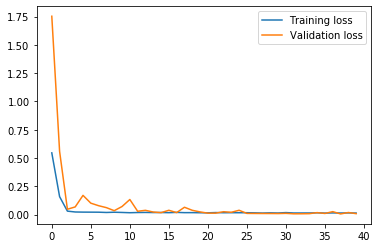

In [12]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [13]:
#Forecasting...
#Start with the last day in training date and predict future...
n_future=90  #Redefining n_future to extend prediction dates beyond original n_future dates...

In [14]:
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [15]:
forecast = model.predict(trainX[-n_future:]) #forecast 

In [16]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [17]:
y_pred_future

array([ 894394.  ,  873294.  ,  869594.94,  887998.75,  882771.2 ,
        882994.56,  886151.  ,  884352.  ,  896676.25,  931759.4 ,
        941537.8 ,  943229.44,  930913.1 ,  918524.56,  909777.  ,
        932747.8 ,  934270.5 ,  937851.25,  935039.8 ,  927288.44,
        931914.5 ,  935409.56,  931914.1 ,  959529.9 ,  946093.5 ,
        935863.9 , 1038620.9 ,  996999.1 , 1001954.5 , 1019101.9 ,
       1078210.1 , 1054040.9 , 1005628.06, 1027003.25, 1045216.8 ,
       1037822.25,  982954.6 ,  982944.2 ,  974592.8 ,  976960.75,
        992657.75,  991531.56,  982128.2 ,  982297.4 ,  981089.3 ,
        978019.  ,  969333.7 ,  948032.5 ,  950256.2 ,  941802.5 ,
        940853.06,  961008.44,  952700.75,  954119.  ,  950613.56,
        946295.94,  952661.75,  926112.44,  883863.5 ,  891749.5 ,
        896756.6 ,  861482.56,  822469.5 ,  823098.44,  838665.6 ,
        854139.7 ,  848746.3 ,  869432.7 ,  885442.25,  886622.7 ,
        886210.2 ,  898911.9 ,  890234.7 ,  897441.25,  894167

In [18]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [19]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [20]:
original = df[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-06-16']

C:\Users\joon7\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


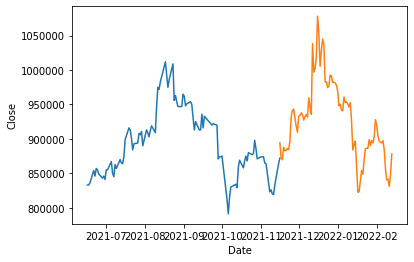

In [21]:
sns.lineplot(original['Date'], original['Close'])
sns.lineplot(df_forecast['Date'], df_forecast['Close'])

30   2021-12-16
Name: Date, dtype: datetime64[ns]
62   2022-01-17
Name: Date, dtype: datetime64[ns]


,Date,Close
0,2021-11-16,8.943940e+05
1,2021-11-17,8.732940e+05
2,2021-11-18,8.695949e+05
3,2021-11-19,8.879988e+05
4,2021-11-20,8.827712e+05
5,2021-11-21,8.829946e+05
6,2021-11-22,8.861510e+05
7,2021-11-23,8.843520e+05
8,2021-11-24,8.966762e+05
9,2021-11-25,9.317594e+05


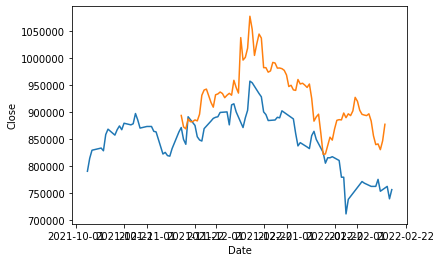

In [22]:
df = web.DataReader('207940.KS', data_source='yahoo', start='2021-06-16', end='2022-02-16')
df = df.reset_index()
df
sns.lineplot(df['Date'][-90:], df['Close'][-90:])
sns.lineplot(df_forecast['Date'], df_forecast['Close'])
#df_forecast['Close']
max_date = df_forecast['Date'][df_forecast['Close'] == max(df_forecast['Close'])]
min_date = df_forecast['Date'][df_forecast['Close'] == min(df_forecast['Close'])]
print(max_date)
print(min_date)
pd.set_option("display.max_rows", None)
df_forecast